In [1]:
#python notebook file which will contain the asset return predictions

## 1.Data Preparation

### 1.1. Importing Modules

In [2]:
import random
import os
import math
import warnings

import pandas as pd
import numpy as np
from numpy.random import seed 
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import optimizers 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.dates as mdates



/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_27409/3791328128.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#setting seed for reproducability
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
#general hyperparameter for lstm
input_steps = 20
output_steps = 1 #1-day ahead predictions

In [5]:
# #general hyperparameter for lstm
# input_steps = 20
# output_steps = 5 #5-day ahead predictions

### 1.2. Defining Functions

In [6]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### 1.3. Loading Data

In [7]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[output_steps:]  # Select all rows except the last rows that contain nan's
        
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

### 1.4. Feature Engineering for LSTM

In [8]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 2
window = 10

In [9]:
data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
1,2020-01-03,company:sap,DE0007164600,95.333333,17.333333,0.791188,0.026211,0.291137,0.106048,0.780920,0.489801,0.850734,0.835793,0.906211,0.697432,120.459999,-0.012623,NaN
2,2020-01-06,company:sap,DE0007164600,298.000000,35.000000,0.892537,0.088522,0.317303,0.082041,0.763958,0.548499,0.824603,0.806162,0.889265,0.645703,119.559998,-0.007471,NaN
3,2020-01-07,company:sap,DE0007164600,562.000000,74.000000,0.882445,0.146300,0.373578,0.039252,0.732300,0.659626,0.735463,0.717746,0.834224,0.527492,120.099998,0.004517,NaN
4,2020-01-08,company:sap,DE0007164600,308.000000,72.000000,0.808901,0.114321,0.391818,0.026917,0.723788,0.695872,0.698831,0.679806,0.808647,0.482434,120.820000,0.005995,NaN
5,2020-01-09,company:sap,DE0007164600,614.000000,35.000000,0.944700,0.162212,0.413270,0.016220,0.714215,0.737301,0.632411,0.621633,0.771828,0.423609,123.160004,0.019368,0.009508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,0.152480,0.316741,0.242918,0.575861,0.481373,0.488924,0.491896,0.708242,0.705679,141.880005,-0.001126,0.039871
1024,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,0.033575,0.232652,0.204379,0.591840,0.274185,0.645581,0.639468,0.788925,0.842664,144.860001,0.021004,0.056755
1025,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,0.087131,0.183343,0.180924,0.600090,0.158884,0.729287,0.719783,0.836897,0.903701,144.559998,-0.002071,0.041649
1026,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,0.089140,0.154060,0.180923,0.596919,0.095371,0.784580,0.771430,0.868094,0.937094,144.580002,0.000138,0.038053


In [10]:
# Iterate through each item in the dictionary
for ticker, df in data_dict.items():
    # Check if '1d_return' column exists in the DataFrame
    if '1d_return' in df.columns:
        # Directly calculate and assign rolling mean and standard deviation to new columns
        df['Rolling_Mean'] = df['1d_return'].rolling(window=window).mean()
        df['Rolling_Std'] = df['1d_return'].rolling(window=window).std()

        # Disregard the initial rows where rolling metrics cannot be calculated
        df = df.iloc[window-1:].reset_index(drop=True)

        # Update the DataFrame in the dictionary
        data_dict[ticker] = df
        print(f'Updated DataFrame for {ticker} by adding rolmean and rolstd and disregarding initial {window-1} rows')


Updated DataFrame for ABI_BR by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ADYEN_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AD_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AIR_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for AI_PA by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ALV_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for ASML_AS by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAS_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BAYN_DE by adding rolmean and rolstd and disregarding initial 9 rows
Updated DataFrame for BBVA_MC by adding rolmean and rolstd and disregarding initial 9 rows
Updated

In [11]:
data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
0,2020-01-16,company:sap,DE0007164600,500.000000,56.000000,0.897849,0.174417,0.439122,0.000575,0.756429,0.787058,0.369068,0.390774,0.000000,0.355679,122.440002,-0.004553,-0.005846,0.000396,0.008912
1,2020-01-17,company:sap,DE0007164600,238.666667,21.333333,0.876859,0.066378,0.438225,0.007300,0.750986,0.789660,0.364157,0.388163,0.000000,0.364931,125.959999,0.028749,0.017776,0.004533,0.011441
2,2020-01-20,company:sap,DE0007164600,416.000000,37.000000,0.916484,0.111849,0.428606,0.018576,0.751757,0.778207,0.386093,0.406379,0.636270,0.392738,125.660004,-0.002382,0.015352,0.005042,0.010950
3,2020-01-21,company:sap,DE0007164600,652.000000,51.000000,0.926241,0.182141,0.426915,0.028665,0.752496,0.775088,0.376537,0.397859,0.634397,0.406379,126.199997,0.004297,0.021036,0.005020,0.010951
4,2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,0.176425,0.433486,0.076607,0.748216,0.788428,0.337232,0.366994,0.614458,0.393209,126.599998,0.003170,0.029268,0.004737,0.010960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,0.152480,0.316741,0.242918,0.575861,0.481373,0.488924,0.491896,0.708242,0.705679,141.880005,-0.001126,0.039871,0.001491,0.009583
1014,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,0.033575,0.232652,0.204379,0.591840,0.274185,0.645581,0.639468,0.788925,0.842664,144.860001,0.021004,0.056755,0.003734,0.011296
1015,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,0.087131,0.183343,0.180924,0.600090,0.158884,0.729287,0.719783,0.836897,0.903701,144.559998,-0.002071,0.041649,0.003641,0.011344
1016,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,0.089140,0.154060,0.180923,0.596919,0.095371,0.784580,0.771430,0.868094,0.937094,144.580002,0.000138,0.038053,0.005189,0.009345


### 1.5. Pre-Processing for ARIMA (Determining Best ARIMA models & Generating Train/Test Sets)

In [12]:
#hyperparameter for train/test split
train_test_ratio = 0.8

In [13]:
for ticker, df in data_dict.items():
    # Check if 'date' column exists in the DataFrame
    if 'date' in df.columns:
        # Convert 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'])
        # Set the 'date' column as the index
        df = df.set_index('date')
        # Update the DataFrame in the dictionary
        data_dict[ticker] = df
        print(f'Updated DataFrame for {ticker} with date as index')


Updated DataFrame for ABI_BR with date as index
Updated DataFrame for ADS_DE with date as index
Updated DataFrame for ADYEN_AS with date as index
Updated DataFrame for AD_AS with date as index
Updated DataFrame for AIR_PA with date as index
Updated DataFrame for AI_PA with date as index
Updated DataFrame for ALV_DE with date as index
Updated DataFrame for ASML_AS with date as index
Updated DataFrame for BAS_DE with date as index
Updated DataFrame for BAYN_DE with date as index
Updated DataFrame for BBVA_MC with date as index
Updated DataFrame for BMW_DE with date as index
Updated DataFrame for BNP_PA with date as index
Updated DataFrame for BN_PA with date as index
Updated DataFrame for CRH with date as index
Updated DataFrame for CS_PA with date as index
Updated DataFrame for DB1_DE with date as index
Updated DataFrame for DG_PA with date as index
Updated DataFrame for DHL_DE with date as index
Updated DataFrame for DTE_DE with date as index
Updated DataFrame for EL_PA with date as in

In [14]:
data_dict['SAP_DE']['1d_return']

date
2020-01-16   -0.004553
2020-01-17    0.028749
2020-01-20   -0.002382
2020-01-21    0.004297
2020-01-22    0.003170
                ...   
2024-01-11   -0.001126
2024-01-12    0.021004
2024-01-15   -0.002071
2024-01-16    0.000138
2024-01-17    0.001660
Name: 1d_return, Length: 1018, dtype: float64

In [15]:
# Initialize dictionaries to store the train and test sets for each ticker
train_dict_arima = {}
test_dict_arima = {}

for ticker, df in data_dict.items():
    # Check if '1d_return' column exists in the DataFrame
    if '1d_return' in df.columns:
        # Perform train-test split
        train, test = train_test_split(df['1d_return'], test_size=1-train_test_ratio, shuffle=False)
        
        # Store the train and test sets in the respective dictionaries
        train_dict_arima[ticker] = train
        test_dict_arima[ticker] = test
        
        print(f'Train and test sets created for {ticker}')

Train and test sets created for ABI_BR
Train and test sets created for ADS_DE
Train and test sets created for ADYEN_AS
Train and test sets created for AD_AS
Train and test sets created for AIR_PA
Train and test sets created for AI_PA
Train and test sets created for ALV_DE
Train and test sets created for ASML_AS
Train and test sets created for BAS_DE
Train and test sets created for BAYN_DE
Train and test sets created for BBVA_MC
Train and test sets created for BMW_DE
Train and test sets created for BNP_PA
Train and test sets created for BN_PA
Train and test sets created for CRH
Train and test sets created for CS_PA
Train and test sets created for DB1_DE
Train and test sets created for DG_PA
Train and test sets created for DHL_DE
Train and test sets created for DTE_DE
Train and test sets created for EL_PA
Train and test sets created for ENEL_MI
Train and test sets created for ENI_MI
Train and test sets created for FLTR_L
Train and test sets created for IBE_MC
Train and test sets created 

In [16]:
train_dict_arima['SAP_DE']

date
2020-01-16   -0.004553
2020-01-17    0.028749
2020-01-20   -0.002382
2020-01-21    0.004297
2020-01-22    0.003170
                ...   
2023-03-16    0.039306
2023-03-17   -0.009410
2023-03-20    0.012189
2023-03-21    0.007969
2023-03-22   -0.000527
Name: 1d_return, Length: 814, dtype: float64

In [17]:
test_dict_arima['SAP_DE']

date
2023-03-23    0.007910
2023-03-24   -0.006104
2023-03-27    0.003334
2023-03-28   -0.005422
2023-03-29    0.007561
                ...   
2024-01-11   -0.001126
2024-01-12    0.021004
2024-01-15   -0.002071
2024-01-16    0.000138
2024-01-17    0.001660
Name: 1d_return, Length: 204, dtype: float64

In [18]:
# Initialize a dictionary to store the auto ARIMA results
autoarima_dict = {}

for ticker, train_series in train_dict_arima.items():
    print(f"Running auto ARIMA for {ticker}...")
    model = auto_arima(train_series, 
                       start_p=0, start_q=0,  # minimum p and q
                       test='adf',            # use augmented dickey-fuller test to find optimal 'd'
                       max_p=3, max_q=3,      # maximum p and q
                       d=None,                # let model determine 'd'
                       seasonal=False,        # no seasonality
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)
    
    # Store the model or its parameters in the dictionary
    autoarima_dict[ticker] = model
    print(f"Auto ARIMA for {ticker} completed.")

Running auto ARIMA for ABI_BR...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3859.675, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3857.693, Time=0.03 sec


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3857.693, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3854.973, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3857.675, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
Auto ARIMA for ABI_BR completed.
Running auto ARIMA for ADS_DE...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3690.261, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3688.963, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3688.938, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3687.183, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3688.861, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.366 seconds
Auto ARIMA for ADS_DE completed.
Running auto ARIMA for ADYEN_AS...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3477.775, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]

In [19]:
for ticker, train_series in train_dict_arima.items():
    print(f"Best ARIMA model for {ticker}: {autoarima_dict[ticker].order}")

Best ARIMA model for ABI_BR: (0, 0, 0)
Best ARIMA model for ADS_DE: (0, 0, 0)
Best ARIMA model for ADYEN_AS: (0, 0, 0)
Best ARIMA model for AD_AS: (0, 0, 0)
Best ARIMA model for AIR_PA: (3, 0, 3)
Best ARIMA model for AI_PA: (1, 0, 1)
Best ARIMA model for ALV_DE: (2, 0, 0)
Best ARIMA model for ASML_AS: (0, 0, 0)
Best ARIMA model for BAS_DE: (0, 0, 0)
Best ARIMA model for BAYN_DE: (0, 0, 1)
Best ARIMA model for BBVA_MC: (0, 0, 0)
Best ARIMA model for BMW_DE: (1, 0, 0)
Best ARIMA model for BNP_PA: (0, 0, 0)
Best ARIMA model for BN_PA: (0, 0, 0)
Best ARIMA model for CRH: (0, 0, 0)
Best ARIMA model for CS_PA: (2, 0, 0)
Best ARIMA model for DB1_DE: (2, 0, 0)
Best ARIMA model for DG_PA: (1, 0, 0)
Best ARIMA model for DHL_DE: (0, 0, 1)
Best ARIMA model for DTE_DE: (3, 0, 0)
Best ARIMA model for EL_PA: (0, 0, 0)
Best ARIMA model for ENEL_MI: (0, 0, 0)
Best ARIMA model for ENI_MI: (0, 0, 0)
Best ARIMA model for FLTR_L: (0, 0, 0)
Best ARIMA model for IBE_MC: (2, 0, 0)
Best ARIMA model for IFX_DE:

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4161.643, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4162.940, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4162.455, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4165.928, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4164.305, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4164.799, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4163.077, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4162.347, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4163.945, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.516 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  814
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2085.964
Date:                Mon, 18 Mar 2024   

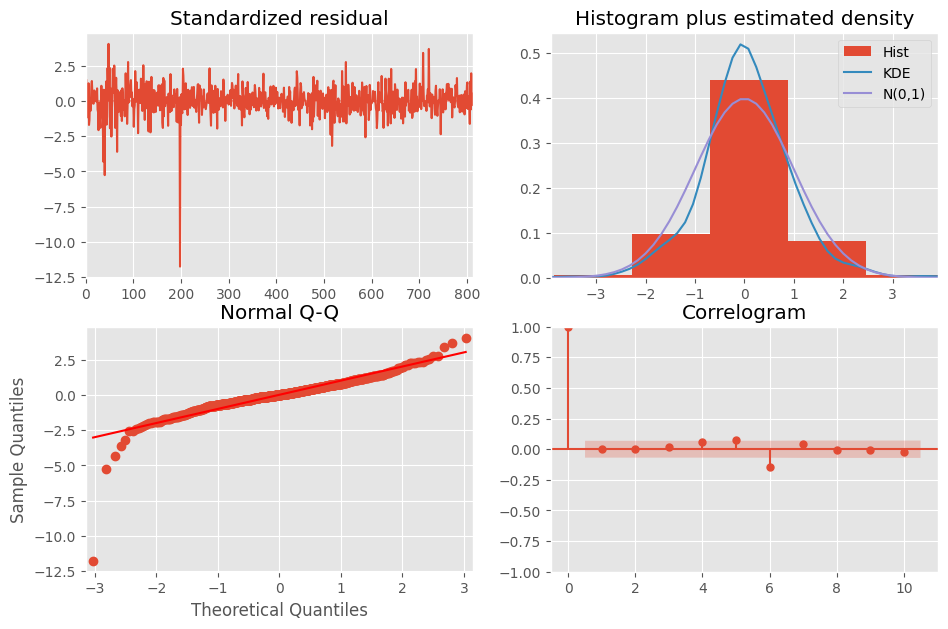

In [20]:
#example with summary and plot
#determining most suitable arima order for sap prediction
autoarima_SAP = auto_arima(train_dict_arima['SAP_DE'], 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SAP.summary())
autoarima_SAP.plot_diagnostics(figsize=(11,7))
plt.show()

### 1.6. Pre-Processing for LSTM (Splitting Sequences & Generating Train/Test Sets)

In [21]:
# #general hyperparameter
# input_steps = 20
# output_steps = 5 # day ahead prediction

In [22]:
# #hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
# n_features = 2
# window = 10

In [23]:
# Initialize dictionaries to store the LSTM input and output sequences for training, validation, and testing
X_train_dict, Y_train_dict = {}, {}
X_val_dict, Y_val_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}

def prepare_sequences(X_seq, Y_seq, n_features, input_steps):
    # Ensure concatenation is done similarly to Method 1
    X_reshaped = np.concatenate([X_seq[0], X_seq[1], X_seq[2]])  # Concatenate along feature axis
    X_reshaped = np.reshape(X_reshaped, (int(X_reshaped.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# Loop through each ticker in the data dictionary
for ticker, df in data_dict.items():
    if '1d_return' in df.columns and 'Rolling_Mean' in df.columns and 'Rolling_Std' in df.columns:
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X1_seq = split_sequence(df['Rolling_Mean'].values, input_steps, output_steps)
        X2_seq = split_sequence(df['Rolling_Std'].values, input_steps, output_steps)
        
        # Concatenate and reshape sequences
        #X_ft, Y = prepare_sequences([X_seq[0], X1_seq[0], X2_seq[0]], X_seq[1], n_features)
        # Corrected function call with all required arguments
        X_ft, Y = prepare_sequences([X_seq[0], X1_seq[0], X2_seq[0]], X_seq[1], n_features, input_steps)

        
        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)
        
        # Store in dictionaries
        X_train_dict[ticker] = X_train
        Y_train_dict[ticker] = Y_train
        X_val_dict[ticker] = X_val
        Y_val_dict[ticker] = Y_val
        X_test_dict[ticker] = X_test
        Y_test_dict[ticker] = Y_test

# Now, X_train_dict, Y_train_dict, X_val_dict, Y_val_dict, X_test_dict, and Y_test_dict 
# contain the train, validation, and test sets for each ticker, respectively.

In [24]:
data_dict['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
date,,,,,,,,,,,,,,,,,,,
2020-01-16,company:sap,DE0007164600,500.000000,56.000000,0.897849,0.174417,0.439122,0.000575,0.756429,0.787058,0.369068,0.390774,0.000000,0.355679,122.440002,-0.004553,-0.005846,0.000396,0.008912
2020-01-17,company:sap,DE0007164600,238.666667,21.333333,0.876859,0.066378,0.438225,0.007300,0.750986,0.789660,0.364157,0.388163,0.000000,0.364931,125.959999,0.028749,0.017776,0.004533,0.011441
2020-01-20,company:sap,DE0007164600,416.000000,37.000000,0.916484,0.111849,0.428606,0.018576,0.751757,0.778207,0.386093,0.406379,0.636270,0.392738,125.660004,-0.002382,0.015352,0.005042,0.010950
2020-01-21,company:sap,DE0007164600,652.000000,51.000000,0.926241,0.182141,0.426915,0.028665,0.752496,0.775088,0.376537,0.397859,0.634397,0.406379,126.199997,0.004297,0.021036,0.005020,0.010951
2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,0.176425,0.433486,0.076607,0.748216,0.788428,0.337232,0.366994,0.614458,0.393209,126.599998,0.003170,0.029268,0.004737,0.010960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,0.152480,0.316741,0.242918,0.575861,0.481373,0.488924,0.491896,0.708242,0.705679,141.880005,-0.001126,0.039871,0.001491,0.009583
2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,0.033575,0.232652,0.204379,0.591840,0.274185,0.645581,0.639468,0.788925,0.842664,144.860001,0.021004,0.056755,0.003734,0.011296
2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,0.087131,0.183343,0.180924,0.600090,0.158884,0.729287,0.719783,0.836897,0.903701,144.559998,-0.002071,0.041649,0.003641,0.011344


In [25]:
X_train_dict['SAP_DE']

array([[[-0.00455283,  0.01462363, -0.00238466],
        [ 0.00039566, -0.0349882 ,  0.0208728 ],
        [ 0.00891154, -0.00089459,  0.01317283],
        ...,
        [ 0.01248023, -0.00443827,  0.01164645],
        [ 0.02470934,  0.01880519,  0.00561278],
        [ 0.00260423,  0.02483336,  0.01248327]],

       [[ 0.02874875,  0.01888163, -0.00138433],
        [ 0.00453283, -0.02139476,  0.02140156],
        [ 0.01144063, -0.00290478, -0.00144463],
        ...,
        [ 0.01462363, -0.00238466, -0.00015768],
        [-0.0349882 ,  0.0208728 ,  0.00711367],
        [-0.00089459,  0.01317283,  0.01044283]],

       [[-0.00238167,  0.01996757,  0.0006513 ],
        [ 0.0050418 ,  0.00133514,  0.02017691],
        [ 0.01094994, -0.00228583, -0.00273265],
        ...,
        [ 0.01888163, -0.00138433,  0.00268136],
        [-0.02139476,  0.02140156,  0.00768643],
        [-0.00290478, -0.00144463,  0.00997005]],

       ...,

       [[-0.01387974,  0.01308412,  0.00268972],
        [-0

In [26]:
#creating two sequence out of which one predicts the other - asset return of dax
X_SAP,Y_SAP = split_sequence(data_dict['SAP_DE']['1d_return'], input_steps, output_steps)

#creating two sequence out of which one predicts the other - features of SAP
X1_SAP,Y1_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Mean'], input_steps, output_steps)

X2_SAP,Y2_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Std'], input_steps, output_steps)

#concatenating input variables for lstm
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])

#reshaping
#X_SAP = np.reshape(X_SAP, (X_SAP.shape[0], input_steps, 1), order='F')
X_ft_SAP = np.reshape(X_ft_SAP, (int(X_ft_SAP.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
Y_SAP = np.reshape(Y_SAP, (Y_SAP.shape[0], output_steps), order='F')

#bringing Y in array form
Y_SAP = [i[output_steps - 1] for i in Y_SAP.tolist()]
Y_SAP = np.array(Y_SAP)

# #splitting sequence into train and test data
# X_ft_train_SAP, X_ft_test_SAP, Y_train_SAP, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle = False) #with features

#splitting sequence into train, val and test data (60-20-20 split)
# First split: Separate out the test set
X_temp, X_ft_test_SAP, Y_temp, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle=False)
# Second split: Split the remaining data into training and validation sets
X_ft_train_SAP, X_ft_val_SAP, Y_train_SAP, Y_val_SAP = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)  # 0.25 * 0.8 = 0.2 # 0.1765 * 0.85 = 0.15

In [27]:
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])
X_ft_SAP.shape

(2994, 20)

In [28]:
X_train_dict['SAP_DE'].shape

(598, 20, 3)

## 2. LSTM & ARIMA: 5-Day Ahead Predictions

### 2.1 LSTM Model & Prediction

In [29]:
#hyperparameter for lstm
epochs = 50
max_trials = 20
patience = 10
verbose = 1

In [30]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [31]:
# def lstm_model(hp):
#     model_LSTM = tf.keras.Sequential()
#     model_LSTM.add(LSTM(
#         units=hp.Int('units', min_value=8, max_value=64, step=8),
#         #activation = hp.Choice("activation", values = ["sigmoid", "tanh", "relu"]),
#         return_sequences=False,
#         input_shape=(input_steps, n_features + 1)))
#     model_LSTM.add(Dense(1))
    
#     # Setting learning rate within the optimizer configuration
#     learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
#     #optimizer = optimizers.Adam(learning_rate=learning_rate)
#     optimizer = Adam(learning_rate=learning_rate) #legacy Adam
    
#     model_LSTM.compile(optimizer=optimizer, loss='mse')
#     return model_LSTM

In [32]:
# tuner = BayesianOptimization(
#     lstm_model,
#     objective='val_loss',
#     max_trials=20,  # Number of trials to run
#     executions_per_trial=1,  # Number of models that should be built and fit for each trial
#     directory='directory',  # Directory to save logs and models
#     project_name='project',
#     overwrite = True
# )

In [33]:
# tuner.search(X_train_dict['SAP_DE'], Y_train_dict['SAP_DE'],
#              epochs=50,
#              validation_data=(X_val_dict['SAP_DE'], Y_val_dict['SAP_DE']),
#              callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

In [34]:
# # best hyperparameters
# best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
# best_hyperparameters = best_trial.hyperparameters.values

# # print the best hyperparameters
# print("Best Hyperparameters:")
# for key, value in best_hyperparameters.items():
#     print(f"{key}: {value}")


In [35]:
# # Retrieve the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history_LSTM_SAP = best_model.fit(X_train_dict['SAP_DE'], Y_train_dict['SAP_DE'], callbacks=[early_stopping], epochs=epochs, verbose=verbose, validation_data=(X_val_dict['SAP_DE'], Y_val_dict['SAP_DE']))

# # Predicting values for SAP asset returns
# yhat_SAP = best_model.predict(X_test_dict['SAP_DE'])

In [36]:
# #plot - loss of lstm sap prediction
# train_loss = history_LSTM_SAP.history['loss']
# val_loss = history_LSTM_SAP.history['val_loss']
# epochs = range(1, len(train_loss) + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_loss, 'bo-', label='training loss')
# plt.plot(epochs, val_loss, 'ro-', label='validation loss')
# plt.title('training and validation loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.tight_layout()


In [37]:
# #bringing yhat in flat form
# #yhat_reshape_SAP = yhat_SAP.reshape(-1,1).reshape(-1,1)
# yhat_flat_SAP = [item for sublist in yhat_SAP.tolist() for item in sublist]

# #review performance of sap lstm
# mse_LSTM = mean_squared_error(yhat_flat_SAP, Y_test_SAP)
# print('MSE_LSTM: '+str("{:e}".format(mse_LSTM)))
# mae_LSTM = mean_absolute_error(yhat_flat_SAP, Y_test_SAP)
# print('MAE_LSTM: '+str("{:e}".format(mae_LSTM)))
# rmse_LSTM = math.sqrt(mean_squared_error(yhat_flat_SAP, Y_test_SAP))
# print('RMSE_LSTM: '+str("{:e}".format(rmse_LSTM)))

In [38]:
# best_model.summary()

In [39]:
#new new code starts here

In [40]:
#hyperparameter for lstm
epochs = 50
max_trials = 20
patience = 10
verbose = 1

In [41]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [42]:
# Function to create an LSTM model with dynamic hyperparameters
def create_lstm_model(input_steps, n_features, units, learning_rate):
    model = tf.keras.Sequential([
        LSTM(units=units, return_sequences=False, input_shape=(input_steps, n_features + 1)),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [43]:
import io
from contextlib import redirect_stdout

def get_model_summary(model):
    with io.StringIO() as buf, redirect_stdout(buf):
        model.summary()
        return buf.getvalue()  # Returns the model summary as a string.


In [44]:
# Function to perform hyperparameter tuning
def lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials):
    def model_builder(hp):
        units = hp.Int('units', min_value=8, max_value=64, step=8)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model = create_lstm_model(input_steps, n_features, units, learning_rate)
        return model

    tuner = BayesianOptimization(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory=f'./lstm_tuning/{company_name}',
        project_name='lstm_hyperparameter_tuning',
        overwrite=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    tuner.search(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hyperparameters

In [45]:
def train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose):
    units = best_hyperparameters.get('units')
    learning_rate = best_hyperparameters.get('learning_rate')
    model = create_lstm_model(input_steps, n_features, units, learning_rate)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(X_train, Y_train, epochs=epochs, verbose=verbose, validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, history


In [46]:
#hp_lstm = {}
results_lstm = {}  # Ensure this is initialized outside the loop

for company_name, X_train in X_train_dict.items():
    Y_train = Y_train_dict[company_name]
    X_val = X_val_dict[company_name]
    Y_val = Y_val_dict[company_name]
    input_steps = X_train.shape[1]
    n_features = X_train.shape[2]  # Assuming the target feature has already been excluded

    # Perform hyperparameter tuning to find the best model parameters
    print(f"Hyperparameter tuning for {company_name}...")
    best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features - 1, company_name, epochs, max_trials=20)  # Ensure n_features is correctly adjusted if needed

    # Train the final model with the best hyperparameters
    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features - 1, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    # Predict and flatten the output
    yhat = model.predict(X_test_dict[company_name])
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    # Calculate performance metrics
    mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    # Store predictions, metrics, and training history
    results_lstm[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

# Visualization or further analysis of training and validation loss can now be done using the 'History' key in results_lstm


Trial 20 Complete [00h 00m 19s]
val_loss: 0.000534469319973141

Best val_loss So Far: 0.0005303558427840471
Total elapsed time: 00h 07m 00s
Final training and prediction for VOW3_DE...
Epoch 1/50
19/19 [==============================] - 4s 40ms/step - loss: 8.1017e-04 - val_loss: 5.3263e-04
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0679e-04 - val_loss: 5.3277e-04
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0544e-04 - val_loss: 5.3257e-04
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0076e-04 - val_loss: 5.3508e-04
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0178e-04 - val_loss: 5.3329e-04
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 8.0210e-04 - val_loss: 5.3228e-04
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 7.9988e-04 - val_loss: 5.3254e-04
Epoch 8/50
19/19 [==============================] - 0s 5ms/step - loss: 

In [47]:
# hp_lstm = {}
# results_lstm = {}

# for company_name, X_train in X_train_dict.items():
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Subtract 1 to exclude target feature from count

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name)
    
#     print(f"Final training and prediction for {company_name}...")
#     model = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features)
#     model_summary = get_model_summary(model)
#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]
    
#     # Calculate performance metrics
#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     # Store predictions, metrics, and model summary
#     results_lstm[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


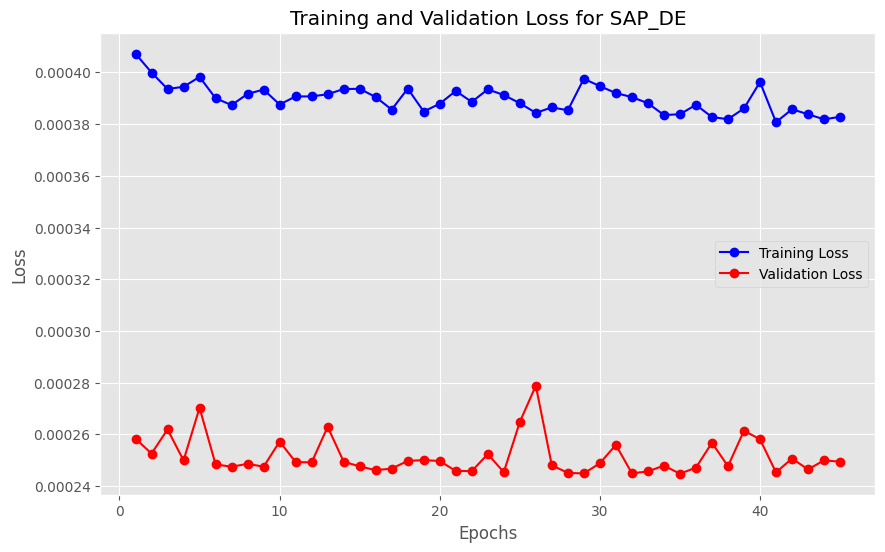

In [48]:
company_name = 'SAP_DE'  # Example company
history_data = results_lstm[company_name]['History']

train_loss = history_data['loss']
val_loss = history_data['val_loss']
epochs_range = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title(f'Training and Validation Loss for {company_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2 ARIMA Model & Prediction

In [49]:
#looking at arima model summary for one stock - SAP
company_name = 'SAP_DE'
model_arima = ARIMA(train_dict_arima[company_name], order=autoarima_dict[company_name].order)  
fitted = model_arima.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              1d_return   No. Observations:                  814
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2085.973
Date:                Tue, 19 Mar 2024   AIC                          -4163.945
Time:                        00:20:19   BIC                          -4145.138
Sample:                             0   HQIC                         -4156.726
                                - 814                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.562e-05      0.001      0.117      0.907      -0.001       0.002
ar.L1         -0.0582      0.038     -1.533      0.125      -0.133       0.016
ar.L2          0.0781      0.029      2.665      0.0

/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
def arima_model(train_data, test_data, order, output_steps):
    # Fit ARIMA model
    model_arima = ARIMA(train_data, order=order)
    fitted_model = model_arima.fit()
    
    # ARIMA prediction
    history = [x for x in train_data]
    predictions = []
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=output_steps)
        yhat = output[output_steps - 1]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
    
    # Flat predictions
    predicted_flat = [float(i) for i in predictions]
    
    # Performance review
    mse = mean_squared_error(test_data, predicted_flat)
    mae = mean_absolute_error(test_data, predicted_flat)
    rmse = math.sqrt(mse)
    
    return mse, mae, rmse, predicted_flat, fitted_model.summary()


In [51]:
warnings.filterwarnings("ignore")

results_arima = {}
for company, train_data in train_dict_arima.items():
    test_data = test_dict_arima[company]
    order = autoarima_dict[company].order
    output_steps = output_steps  # Adjust this if necessary
    
    mse, mae, rmse, predicted_flat, summary = arima_model(train_data, test_data, order, output_steps)
    results_arima[company] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': predicted_flat,
        'Summary': summary
    }
    print(f'{company} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


ABI_BR - MSE: 1.364331e-04, MAE: 8.598626e-03, RMSE: 1.168046e-02
ADS_DE - MSE: 4.219235e-04, MAE: 1.442171e-02, RMSE: 2.054078e-02
ADYEN_AS - MSE: 1.929409e-03, MAE: 2.050495e-02, RMSE: 4.392504e-02
AD_AS - MSE: 1.229963e-04, MAE: 7.257934e-03, RMSE: 1.109037e-02
AIR_PA - MSE: 1.441701e-04, MAE: 9.147679e-03, RMSE: 1.200709e-02
AI_PA - MSE: 9.904761e-05, MAE: 7.328191e-03, RMSE: 9.952267e-03
ALV_DE - MSE: 1.048406e-04, MAE: 7.150788e-03, RMSE: 1.023917e-02
ASML_AS - MSE: 2.850741e-04, MAE: 1.257402e-02, RMSE: 1.688414e-02
BAS_DE - MSE: 2.457647e-04, MAE: 1.164510e-02, RMSE: 1.567688e-02
BAYN_DE - MSE: 3.557161e-04, MAE: 1.094120e-02, RMSE: 1.886044e-02
BBVA_MC - MSE: 2.109412e-04, MAE: 1.109499e-02, RMSE: 1.452381e-02
BMW_DE - MSE: 2.278543e-04, MAE: 1.055144e-02, RMSE: 1.509484e-02
BNP_PA - MSE: 2.030488e-04, MAE: 1.048835e-02, RMSE: 1.424952e-02
BN_PA - MSE: 7.717870e-05, MAE: 6.724415e-03, RMSE: 8.785141e-03
CRH - MSE: 2.344150e-04, MAE: 1.147174e-02, RMSE: 1.531062e-02
CS_PA - MSE

### 2.3 Comparison between LSTM & ARIMA Predictions - SAP

In [52]:
# Placeholder for storing all companies' comparison results
results_comp = {}

for company in data_dict.keys():
    # Determine the minimum length for comparison across LSTM and ARIMA predictions
    min_comp = min(len(results_lstm[company]['Predictions']), len(results_arima[company]['Predictions']))
    
    # Extract the relevant portions of predictions
    pred_lstm = pd.Series(results_lstm[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_arima = pd.Series(results_arima[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Assuming Y_test_dict is similarly structured to data_dict and results dicts
    actual = pd.Series(Y_test_dict[company][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Concatenate actual values and predictions for LSTM and ARIMA into one DataFrame
    predictions = pd.concat([actual, pred_lstm, pred_arima], axis=1, keys=['actual', 'pred_lstm', 'pred_arima'])
    
    # Store the combined DataFrame in the results_comp dictionary
    results_comp[company] = predictions

# Now, results_comp contains the actual values and predictions from both LSTM and ARIMA models for each company.


In [53]:
results_comp['SAP_DE']

,actual,pred_lstm,pred_arima
date,,,
2023-03-29,0.007561,0.005126,0.000662
2023-03-30,0.006632,0.004104,-0.000777
2023-03-31,0.006068,0.002099,0.000306
2023-04-03,-0.003963,0.004360,0.000275
2023-04-04,0.006401,0.002578,0.000810
...,...,...,...
2024-01-11,-0.001126,0.001034,-0.000607
2024-01-12,0.021004,0.002141,0.001872
2024-01-15,-0.002071,0.001704,-0.001022


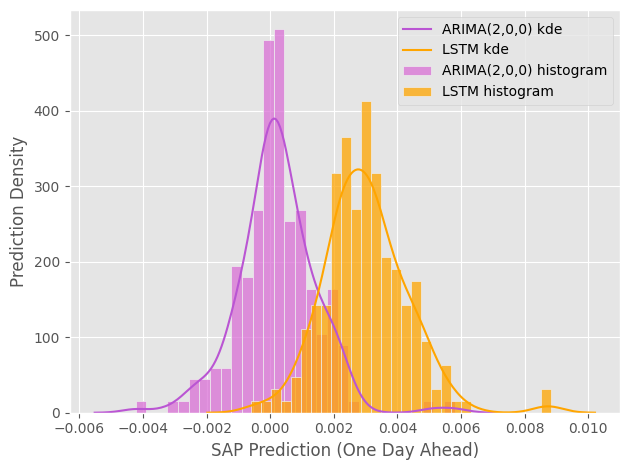

In [101]:
# Setting up the bins parameter for consistency across histograms
bins = 30  # Adjust the number of bins as needed

# ARIMA Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_arima', bins=bins, color='orchid', stat='density', label='ARIMA(2,0,0) histogram')

# ARIMA KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_arima', color='mediumorchid', label='ARIMA(2,0,0) kde')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm', bins=bins, color='orange', stat='density', label='LSTM histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm', color='orange', label='LSTM kde')

# Actual Histogram
#sns.histplot(data=results_comp['SAP_DE'], x='actual', bins=bins, color='blue', stat='density', label='Actual histogram')

# Actual KDE
#sns.kdeplot(data=results_comp['SAP_DE'], x='actual', color='blue', label='Actual kernel density estimation')

# Adding labels and adjusting layout
plt.xlabel('SAP Prediction (One Day Ahead)')
plt.ylabel('Prediction Density')
plt.tight_layout()
plt.legend()

# Uncomment the following line if you want to save the figure
#plt.savefig('hist_pred_sap.png')

plt.show()


In [55]:
# #plot - sap asset return predictions
# plt.plot(results_comp['SAP_DE']['actual'][0:50], color= 'blue', label = 'Actual')
# plt.plot(results_comp['SAP_DE']['pred_lstm'][0:50], color= 'orange', label = 'LSTM (epochs = 10)', linewidth = 3)
# plt.plot(results_comp['SAP_DE']['pred_arima'][0:50], color= 'darkorchid', label = 'ARIMA(2,0,0)', linewidth = 3)
# plt.xlabel('Date')
# plt.ylabel('SAP Asset Returns')
# plt.legend()
# plt.tight_layout()
# #plt.savefig('pred_sap_1.png')

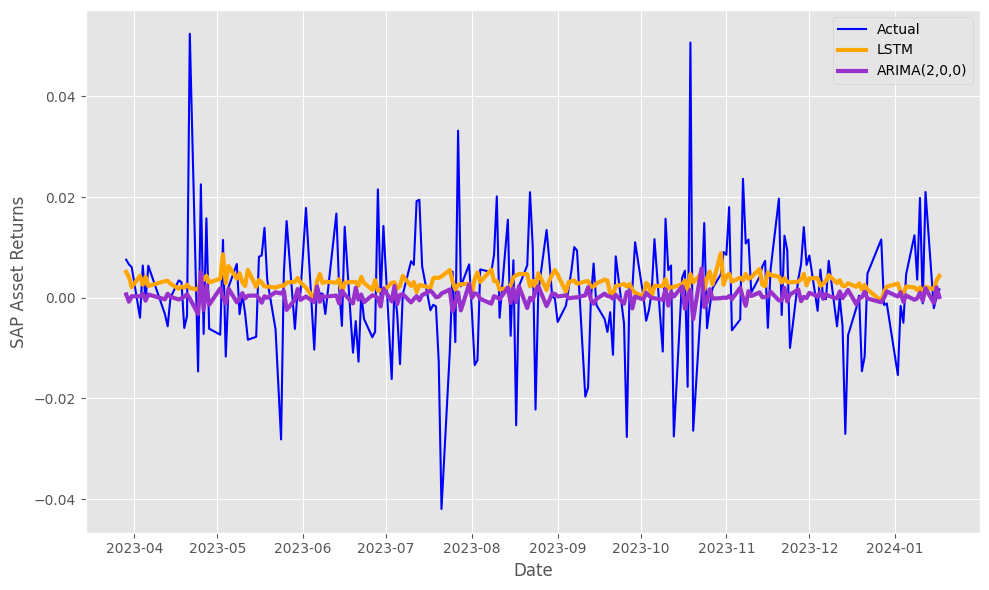

In [92]:
import matplotlib.dates as mdates

# Assuming results_comp['SAP_DE'] has a DateTimeIndex or the date information can be extracted
dates = results_comp['SAP_DE'].index  # Extract the dates corresponding to your data

#plot - sap asset return predictions
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size as needed
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA(2,0,0)', linewidth=3)

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
#plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()

plt.show()

In [57]:
def calculate_metrics_comp(results_comp):
    metrics_comp = {}
    
    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0}
        
        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        
        # Calculate confusion matrix for ARIMA and LSTM
        for actual, pred_arima, pred_lstm in zip(actual_sign, pred_arima_sign, pred_lstm_sign):
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1
                
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1
        
        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy
        
        # Calculate metrics for ARIMA
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        
        # Calculate metrics for LSTM
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        
        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm}
        }
        
    return metrics_comp

# Assuming results_comp has been populated as in previous examples
# metrics_comp = calculate_metrics_comp(results_comp)
# This will calculate and store Precision, Recall, F1 Score, and Accuracy for each company, for both ARIMA and LSTM models.


In [58]:
metrics_comp = calculate_metrics_comp(results_comp)

# Loop over all companies in metrics_comp to print their metrics
for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print("\n")  # Adds a newline for better readability between companies


Metrics for ABI_BR - ARIMA:
{'TP': 32, 'FP': 30, 'TN': 65, 'FN': 75, 'Precision': 0.5161, 'Recall': 0.2991, 'F1': 0.3787, 'Accuracy': 0.4802}
Metrics for ABI_BR - LSTM:
{'TP': 67, 'FP': 54, 'TN': 41, 'FN': 40, 'Precision': 0.5537, 'Recall': 0.6262, 'F1': 0.5877, 'Accuracy': 0.5347}


Metrics for ADS_DE - ARIMA:
{'TP': 0, 'FP': 0, 'TN': 103, 'FN': 97, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.515}
Metrics for ADS_DE - LSTM:
{'TP': 14, 'FP': 14, 'TN': 89, 'FN': 83, 'Precision': 0.5, 'Recall': 0.1443, 'F1': 0.224, 'Accuracy': 0.515}


Metrics for ADYEN_AS - ARIMA:
{'TP': 101, 'FP': 101, 'TN': 0, 'FN': 0, 'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6667, 'Accuracy': 0.5}
Metrics for ADYEN_AS - LSTM:
{'TP': 24, 'FP': 20, 'TN': 81, 'FN': 77, 'Precision': 0.5455, 'Recall': 0.2376, 'F1': 0.331, 'Accuracy': 0.5198}


Metrics for AD_AS - ARIMA:
{'TP': 107, 'FP': 95, 'TN': 0, 'FN': 0, 'Precision': 0.5297, 'Recall': 1.0, 'F1': 0.6926, 'Accuracy': 0.5297}
Metrics for AD_AS - LSTM:
{'TP': 5

## 3. LSTM with News Analytics Data

### 3.1. Pre-Processing for LSTM (Splitting Sequences & Generating Train/Test Sets)

In [59]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 4
window = 10

In [60]:
data_dict['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
date,,,,,,,,,,,,,,,,,,,
2020-01-16,company:sap,DE0007164600,500.000000,56.000000,0.897849,0.174417,0.439122,0.000575,0.756429,0.787058,0.369068,0.390774,0.000000,0.355679,122.440002,-0.004553,-0.005846,0.000396,0.008912
2020-01-17,company:sap,DE0007164600,238.666667,21.333333,0.876859,0.066378,0.438225,0.007300,0.750986,0.789660,0.364157,0.388163,0.000000,0.364931,125.959999,0.028749,0.017776,0.004533,0.011441
2020-01-20,company:sap,DE0007164600,416.000000,37.000000,0.916484,0.111849,0.428606,0.018576,0.751757,0.778207,0.386093,0.406379,0.636270,0.392738,125.660004,-0.002382,0.015352,0.005042,0.010950
2020-01-21,company:sap,DE0007164600,652.000000,51.000000,0.926241,0.182141,0.426915,0.028665,0.752496,0.775088,0.376537,0.397859,0.634397,0.406379,126.199997,0.004297,0.021036,0.005020,0.010951
2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,0.176425,0.433486,0.076607,0.748216,0.788428,0.337232,0.366994,0.614458,0.393209,126.599998,0.003170,0.029268,0.004737,0.010960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,0.152480,0.316741,0.242918,0.575861,0.481373,0.488924,0.491896,0.708242,0.705679,141.880005,-0.001126,0.039871,0.001491,0.009583
2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,0.033575,0.232652,0.204379,0.591840,0.274185,0.645581,0.639468,0.788925,0.842664,144.860001,0.021004,0.056755,0.003734,0.011296
2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,0.087131,0.183343,0.180924,0.600090,0.158884,0.729287,0.719783,0.836897,0.903701,144.559998,-0.002071,0.041649,0.003641,0.011344


In [61]:
# #general hyperparameter
# input_steps = 20
# output_steps = 5 # day ahead prediction

In [62]:
# Initialize dictionaries to store the LSTM input and output sequences for training, validation, and testing
X_train_dict, Y_train_dict = {}, {}
X_val_dict, Y_val_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}

def prepare_sequences(X_seqs, Y_seq, input_steps):
    # Concatenate along feature axis for all provided X sequences
    X_reshaped = np.concatenate(X_seqs, axis=1)
    X_reshaped = np.reshape(X_reshaped, (-1, input_steps, len(X_seqs)))
    Y_reshaped = np.array([y[output_steps - 1] for y in Y_seq])
    return X_reshaped, Y_reshaped

# Loop through each ticker in the data dictionary
for ticker, df in data_dict.items():
    required_features = ['1d_return', 'sentiment', 'volume', 'esg_score', 'general_risk_score']
    if all(feature in df.columns for feature in required_features):
        # Generate sequences for each feature and the target
        X_seq = split_sequence(df['1d_return'].values, input_steps, output_steps)
        X_seqs = [split_sequence(df[feature].values, input_steps, output_steps)[0] for feature in required_features[1:]]
        
        # Concatenate and reshape sequences
        X_ft, Y = prepare_sequences(X_seqs, X_seq[1], input_steps)

        # Split into train, validation, and test sets
        X_temp, X_test, Y_temp, Y_test = train_test_split(X_ft, Y, test_size=0.2, shuffle=False)
        X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, shuffle=False)
        
        # Store in dictionaries
        X_train_dict[ticker] = X_train
        Y_train_dict[ticker] = Y_train
        X_val_dict[ticker] = X_val
        Y_val_dict[ticker] = Y_val
        X_test_dict[ticker] = X_test
        Y_test_dict[ticker] = Y_test


In [63]:
X_train_dict['SAP_DE'].shape

(598, 20, 4)

In [64]:
X_test_dict['SAP_DE'].shape

(200, 20, 4)

### 3.1. LSTM w/ News Analytics Data: Model & Prediction

In [65]:
#hyperparameter for lstm
epochs = 50
max_trials = 20
patience = 10
verbose = 1

In [66]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [67]:
X_train.shape[1]

20

In [68]:
results_lstm_nad = {}  # Initialized with the new name

for company_name, X_train in X_train_dict.items():
    X_train = X_train_dict[company_name]
    Y_train = Y_train_dict[company_name]
    X_val = X_val_dict[company_name]
    Y_val = Y_val_dict[company_name]
    input_steps = X_train.shape[1]
    # Adjust n_features based on your new data structure
    n_features = X_train.shape[2] - 1  # Subtract 1 to exclude target feature from count, adjust as necessary

    print(f"Hyperparameter tuning for {company_name}...")
    best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

    print(f"Final training and prediction for {company_name}...")
    model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
    model_summary = get_model_summary(model)

    yhat = model.predict(X_test_dict[company_name])
    yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

    mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
    mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
    rmse = math.sqrt(mse)

    results_lstm_nad[company_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Predictions': yhat_flat,
        'History': history.history,  # Store the training and validation loss over epochs
        'Summary': model_summary
    }

    print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


Trial 20 Complete [00h 02m 16s]
val_loss: 0.0005781236104667187

Best val_loss So Far: 0.0005301669589243829
Total elapsed time: 00h 48m 28s
Final training and prediction for VOW3_DE...
Epoch 1/50
19/19 [==============================] - 7s 90ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 5.4930e-04
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 8.1331e-04 - val_loss: 5.5926e-04
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 8.3140e-04 - val_loss: 5.3666e-04
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 8.0410e-04 - val_loss: 5.3660e-04
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 8.0404e-04 - val_loss: 5.4007e-04
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 8.2766e-04 - val_loss: 6.2872e-04
Epoch 8/50
19/19 [==============================] - 0s 4ms/step - loss: 8.3333e-04 

In [69]:
# Assuming data_dict is a dictionary with company names as keys and dataframes as values
# Assuming input_steps and n_features have been defined according to your LSTM model

# Define expected input shape based on your LSTM model's configuration
expected_input_shape = (input_steps, n_features + 1)

# Placeholder for items with mismatched shapes
mismatched_shapes = {}

# Loop over each item in data_dict
for company, df in data_dict.items():
    # Assuming the X_train and X_val have already been prepared for this company
    X_train = X_train_dict[company]
    X_val = X_val_dict[company]

    # Check if the shapes match the expected input shape of the LSTM model
    actual_input_shape_train = X_train.shape[1:]
    actual_input_shape_val = X_val.shape[1:]
    
    if not (expected_input_shape == actual_input_shape_train == actual_input_shape_val):
        mismatched_shapes[company] = {
            'Expected': expected_input_shape,
            'Actual Train': actual_input_shape_train,
            'Actual Val': actual_input_shape_val
        }

mismatched_shapes


{}

In [70]:
# Assuming X_train_dict, Y_train_dict, X_val_dict, Y_val_dict are the dictionaries containing your data
# Let's iterate through each company and check for empty datasets or unexpected shapes

empty_or_unexpected_shape = {}

# Check X_train_dict and Y_train_dict
for company, data in X_train_dict.items():
    x_train_shape = data.shape
    y_train_shape = Y_train_dict[company].shape
    x_val_shape = X_val_dict[company].shape
    y_val_shape = Y_val_dict[company].shape
    
    # Checking if any of the datasets are empty
    if data.size == 0 or Y_train_dict[company].size == 0 or X_val_dict[company].size == 0 or Y_val_dict[company].size == 0:
        empty_or_unexpected_shape[company] = "Empty dataset found"
        continue  # Skip further checks if the dataset is empty
    
    # Assuming expected shapes for simplicity, adjust according to your actual expected shapes
    # Example expected shapes: X_train and X_val (any_length, 20, n_features), Y_train and Y_val (any_length,)
    if len(x_train_shape) != 3 or x_train_shape[1] != 20 or len(y_train_shape) != 1 or \
       len(x_val_shape) != 3 or x_val_shape[1] != 20 or len(y_val_shape) != 1:
        empty_or_unexpected_shape[company] = f"Unexpected shape: X_train: {x_train_shape}, Y_train: {y_train_shape}, X_val: {x_val_shape}, Y_val: {y_val_shape}"

empty_or_unexpected_shape


{}

In [71]:
required_features = ['1d_return', 'sentiment', 'volume', 'esg_score', 'general_risk_score']

def inspect_data(data_dict, required_features):
    report = {}
    for ticker, df in data_dict.items():
        feature_report = {}
        for feature in required_features:
            if feature not in df.columns:
                feature_report[feature] = "Feature not present"
                continue
            
            feature_data = df[feature]
            nans = feature_data.isna().sum()
            infinities = (feature_data == np.inf).sum() + (feature_data == -np.inf).sum()
            zeros = (feature_data == 0).sum()
            
            feature_report[feature] = {
                "NaNs": nans,
                "Infinities": infinities,
                "Zeros": zeros,
                "Total": len(feature_data)
            }
            
        report[ticker] = feature_report
    
    return report

# Since the data_dict isn't currently defined in this execution environment, this function cannot be directly executed.
# However, you would run it using something like this:
data_inspection_report = inspect_data(data_dict, required_features)
print(data_inspection_report)

# This is a placeholder response to illustrate how you could proceed. Please adapt it to your actual code environment.


{'ABI_BR': {'1d_return': {'NaNs': 0, 'Infinities': 0, 'Zeros': 6, 'Total': 1029}, 'sentiment': {'NaNs': 0, 'Infinities': 0, 'Zeros': 0, 'Total': 1029}, 'volume': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1029}, 'esg_score': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1029}, 'general_risk_score': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1029}}, 'ADS_DE': {'1d_return': {'NaNs': 0, 'Infinities': 0, 'Zeros': 17, 'Total': 1018}, 'sentiment': {'NaNs': 0, 'Infinities': 0, 'Zeros': 0, 'Total': 1018}, 'volume': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1018}, 'esg_score': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1018}, 'general_risk_score': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1018}}, 'ADYEN_AS': {'1d_return': {'NaNs': 0, 'Infinities': 0, 'Zeros': 1, 'Total': 1029}, 'sentiment': {'NaNs': 0, 'Infinities': 0, 'Zeros': 0, 'Total': 1029}, 'volume': {'NaNs': 0, 'Infinities': 0, 'Zeros': 14, 'Total': 1029}, 'esg_score': {'NaNs': 0, 'Infinities': 0,

In [72]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)


X_train shape: (598, 20, 4)
X_val shape: (200, 20, 4)
Y_train shape: (598,)
Y_val shape: (200,)


In [73]:
import numpy as np

# Assuming your data is in NumPy arrays. For Pandas DataFrames, use df.isna().any() or df.isin([np.nan, np.inf, -np.inf]).any()
print("NaNs in X_train:", np.isnan(X_train).any())
print("Infinities in X_train:", np.isinf(X_train).any())

print("NaNs in X_val:", np.isnan(X_val).any())
print("Infinities in X_val:", np.isinf(X_val).any())

print("NaNs in Y_train:", np.isnan(Y_train).any())
print("Infinities in Y_train:", np.isinf(Y_train).any())

print("NaNs in Y_val:", np.isnan(Y_val).any())
print("Infinities in Y_val:", np.isinf(Y_val).any())


NaNs in X_train: False
Infinities in X_train: False
NaNs in X_val: False
Infinities in X_val: False
NaNs in Y_train: False
Infinities in Y_train: False
NaNs in Y_val: False
Infinities in Y_val: False


In [74]:
import pandas as pd

# Iterate through each company in X_train_dict
for company_name, X_train in X_train_dict.items():
    # Reshape X_train from 3D to 2D for easier handling
    # Assuming X_train is of shape (samples, timesteps, features)
    num_samples, timesteps, num_features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, num_features)
    
    # Convert the numpy array to a pandas DataFrame for easier NaN checking
    df_X_train = pd.DataFrame(X_train_reshaped)
    
    # Check for columns with NaNs
    cols_with_nans = df_X_train.columns[df_X_train.isna().any()].tolist()
    
    if cols_with_nans:  # If there are columns with NaNs
        print(f"Company: {company_name}, Columns with NaNs: {cols_with_nans}")
        
        # For a more detailed look, you can find the row indices with NaNs in these columns
        for col in cols_with_nans:
            rows_with_nans = df_X_train.index[df_X_train[col].isna()].tolist()
            print(f"    Column: {col}, Rows with NaNs: {rows_with_nans[:10]}")  # Displaying first 10 for brevity
    else:
        print(f"Company: {company_name} has no NaNs in X_train.")


Company: ABI_BR has no NaNs in X_train.
Company: ADS_DE has no NaNs in X_train.
Company: ADYEN_AS has no NaNs in X_train.
Company: AD_AS has no NaNs in X_train.
Company: AIR_PA has no NaNs in X_train.
Company: AI_PA has no NaNs in X_train.
Company: ALV_DE has no NaNs in X_train.
Company: ASML_AS has no NaNs in X_train.
Company: BAS_DE has no NaNs in X_train.
Company: BAYN_DE has no NaNs in X_train.
Company: BBVA_MC has no NaNs in X_train.
Company: BMW_DE has no NaNs in X_train.


Company: BNP_PA has no NaNs in X_train.
Company: BN_PA has no NaNs in X_train.
Company: CRH has no NaNs in X_train.
Company: CS_PA has no NaNs in X_train.
Company: DB1_DE has no NaNs in X_train.
Company: DG_PA has no NaNs in X_train.
Company: DHL_DE has no NaNs in X_train.
Company: DTE_DE has no NaNs in X_train.
Company: EL_PA has no NaNs in X_train.
Company: ENEL_MI has no NaNs in X_train.
Company: ENI_MI has no NaNs in X_train.
Company: FLTR_L has no NaNs in X_train.
Company: IBE_MC has no NaNs in X_train.
Company: IFX_DE has no NaNs in X_train.
Company: INGA_AS has no NaNs in X_train.
Company: ISP_MI has no NaNs in X_train.
Company: ITX_MC has no NaNs in X_train.
Company: KER_PA has no NaNs in X_train.
Company: MBG_DE has no NaNs in X_train.
Company: MC_PA has no NaNs in X_train.
Company: MUV2_DE has no NaNs in X_train.
Company: NDA-SE_ST has no NaNs in X_train.
Company: NOKIA_HE has no NaNs in X_train.
Company: OR_PA has no NaNs in X_train.
Company: PRX_AS has no NaNs in X_train.
C

In [75]:
# results_lstm_nad = {}

# # Retrieve the first company name and its corresponding datasets
# company_name, X_train = next(iter(X_train_dict.items()))
# Y_train = Y_train_dict[company_name]
# X_val = X_val_dict[company_name]
# Y_val = Y_val_dict[company_name]

# input_steps = X_train.shape[1]
# n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

# print(f"Hyperparameter tuning for {company_name}...")
# best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

# print(f"Final training and prediction for {company_name}...")
# model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
# model_summary = get_model_summary(model)

# yhat = model.predict(X_test_dict[company_name])
# yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

# mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
# mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
# rmse = math.sqrt(mse)

# results_lstm_nad[company_name] = {
#     'MSE': mse,
#     'MAE': mae,
#     'RMSE': rmse,
#     'Predictions': yhat_flat,
#     'History': history.history,  # Store the training and validation loss over epochs
#     'Summary': model_summary
# }

# print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')


In [76]:
# # For the first 10 companies
# company_names = list(X_train_dict.keys())[:10]

# results_lstm_nad = {}  # Initialize with the new name

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [77]:
# # For companies 10-20
# company_names = list(X_train_dict.keys())[10:20]

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [78]:
# # For companies 20-30
# company_names = list(X_train_dict.keys())[20:30]

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [79]:
# # For companies 30-40
# company_names = list(X_train_dict.keys())[30:40]

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [80]:
# # For the first last companies
# company_names = list(X_train_dict.keys())[40:]

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [81]:
# # For the first last companies
# company_names = list(X_train_dict.keys())[44:]

# for company_name in company_names:
#     X_train = X_train_dict[company_name]
#     Y_train = Y_train_dict[company_name]
#     X_val = X_val_dict[company_name]
#     Y_val = Y_val_dict[company_name]
#     input_steps = X_train.shape[1]
#     n_features = X_train.shape[2] - 1  # Adjust based on your new data structure

#     print(f"Hyperparameter tuning for {company_name}...")
#     best_hyperparameters = lstm_hp(X_train, Y_train, X_val, Y_val, input_steps, n_features, company_name, epochs, max_trials=20)

#     print(f"Final training and prediction for {company_name}...")
#     model, history = train_final_lstm_model(X_train, Y_train, X_val, Y_val, best_hyperparameters, input_steps, n_features, epochs, patience, verbose)
#     model_summary = get_model_summary(model)

#     yhat = model.predict(X_test_dict[company_name])
#     yhat_flat = [item for sublist in yhat.tolist() for item in sublist]

#     mse = mean_squared_error(Y_test_dict[company_name], yhat_flat)
#     mae = mean_absolute_error(Y_test_dict[company_name], yhat_flat)
#     rmse = math.sqrt(mse)

#     results_lstm_nad[company_name] = {
#         'MSE': mse,
#         'MAE': mae,
#         'RMSE': rmse,
#         'Predictions': yhat_flat,
#         'History': history.history,  # Store the training and validation loss over epochs
#         'Summary': model_summary
#     }

#     print(f'{company_name} - MSE: {mse:e}, MAE: {mae:e}, RMSE: {rmse:e}')

In [82]:
print(list(X_train_dict.keys())[44:])

['SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE']


In [83]:
results_lstm_nad

{'ABI_BR': {'MSE': 0.0001414907748125203,
  'MAE': 0.008732280897829162,
  'RMSE': 0.011894989483497676,
  'Predictions': [0.004048880189657211,
   0.00522049143910408,
   0.0037162788212299347,
   0.00557592511177063,
   0.003308746963739395,
   0.0033217407763004303,
   0.00276288203895092,
   0.004179727286100388,
   0.003057613968849182,
   0.0046915411949157715,
   0.003042912110686302,
   0.003999186679720879,
   0.0033059455454349518,
   0.0051471758633852005,
   0.004783939570188522,
   0.005402088165283203,
   0.003905452787876129,
   0.004662670195102692,
   0.004477085545659065,
   0.004525460302829742,
   0.0035987235605716705,
   0.004290765151381493,
   0.0037976503372192383,
   0.00253860279917717,
   0.0025388970971107483,
   0.002615969628095627,
   0.002717830240726471,
   0.002553187310695648,
   0.0021173469722270966,
   0.002108961343765259,
   0.002083849161863327,
   0.001964554190635681,
   0.0014310479164123535,
   0.0014769695699214935,
   0.001563690602779388

### 3.2. Comparison between LSTM & LSTM_NAD & ARIMA Predictions

In [84]:
# Placeholder for storing all companies' comparison results
results_comp = {}

for company in data_dict.keys():
    # Determine the minimum length for comparison across LSTM and ARIMA predictions
    min_comp = min(len(results_lstm[company]['Predictions']), len(results_arima[company]['Predictions']))
    
    # Extract the relevant portions of predictions
    pred_lstm = pd.Series(results_lstm[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_arima = pd.Series(results_arima[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    pred_lstm_nad = pd.Series(results_lstm_nad[company]['Predictions'][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Assuming Y_test_dict is similarly structured to data_dict and results dicts
    actual = pd.Series(Y_test_dict[company][-min_comp:], index=data_dict[company]['1d_return'].iloc[-min_comp:].index)
    
    # Concatenate actual values and predictions for LSTM and ARIMA into one DataFrame
    predictions = pd.concat([actual, pred_lstm, pred_arima, pred_lstm_nad], axis=1, keys=['actual', 'pred_lstm', 'pred_arima', 'pred_lstm_nad'])
    
    # Store the combined DataFrame in the results_comp dictionary
    results_comp[company] = predictions

# Now, results_comp contains the actual values and predictions from both LSTM and ARIMA models for each company.


In [85]:
def calculate_metrics_comp(results_comp):
    metrics_comp = {}

    for company in results_comp.keys():
        # Initialize counters
        metrics = {'tp_arima': 0, 'fp_arima': 0, 'tn_arima': 0, 'fn_arima': 0,
                   'tp_lstm': 0, 'fp_lstm': 0, 'tn_lstm': 0, 'fn_lstm': 0,
                   'tp_lstm_nad': 0, 'fp_lstm_nad': 0, 'tn_lstm_nad': 0, 'fn_lstm_nad': 0}

        # Derive sign columns
        actual_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['actual']]
        pred_arima_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_arima']]
        pred_lstm_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm']]
        pred_lstm_nad_sign = ['Pos' if val >= 0 else 'Neg' for val in results_comp[company]['pred_lstm_nad']]

        # Calculate confusion matrix for ARIMA, LSTM, and LSTM_NAD
        for actual, pred_arima, pred_lstm, pred_lstm_nad in zip(actual_sign, pred_arima_sign, pred_lstm_sign, pred_lstm_nad_sign):
            # ARIMA
            if actual == 'Pos' and pred_arima == 'Pos':
                metrics['tp_arima'] += 1
            elif actual == 'Pos' and pred_arima == 'Neg':
                metrics['fn_arima'] += 1
            elif actual == 'Neg' and pred_arima == 'Neg':
                metrics['tn_arima'] += 1
            else:
                metrics['fp_arima'] += 1
            
            # LSTM
            if actual == 'Pos' and pred_lstm == 'Pos':
                metrics['tp_lstm'] += 1
            elif actual == 'Pos' and pred_lstm == 'Neg':
                metrics['fn_lstm'] += 1
            elif actual == 'Neg' and pred_lstm == 'Neg':
                metrics['tn_lstm'] += 1
            else:
                metrics['fp_lstm'] += 1
            
            # LSTM_NAD
            if actual == 'Pos' and pred_lstm_nad == 'Pos':
                metrics['tp_lstm_nad'] += 1
            elif actual == 'Pos' and pred_lstm_nad == 'Neg':
                metrics['fn_lstm_nad'] += 1
            elif actual == 'Neg' and pred_lstm_nad == 'Neg':
                metrics['tn_lstm_nad'] += 1
            else:
                metrics['fp_lstm_nad'] += 1

        # Function to calculate precision, recall, F1 score, and accuracy
        def calculate_metrics(tp, fp, fn, tn):
            precision = round(tp / (tp + fp) if (tp + fp) else 0, 4)
            recall = round(tp / (tp + fn) if (tp + fn) else 0, 4)
            f1 = round(2 * (precision * recall) / (precision + recall) if (precision + recall) else 0, 4)
            accuracy = round((tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0, 4)
            return precision, recall, f1, accuracy

        # Calculate metrics for ARIMA, LSTM, and LSTM_NAD
        precision_arima, recall_arima, f1_arima, accuracy_arima = calculate_metrics(metrics['tp_arima'], metrics['fp_arima'], metrics['fn_arima'], metrics['tn_arima'])
        precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = calculate_metrics(metrics['tp_lstm'], metrics['fp_lstm'], metrics['fn_lstm'], metrics['tn_lstm'])
        precision_lstm_nad, recall_lstm_nad, f1_lstm_nad, accuracy_lstm_nad = calculate_metrics(metrics['tp_lstm_nad'], metrics['fp_lstm_nad'], metrics['fn_lstm_nad'], metrics['tn_lstm_nad'])

        # Store metrics
        metrics_comp[company] = {
            'ARIMA': {'TP': metrics['tp_arima'], 'FP': metrics['fp_arima'], 'TN': metrics['tn_arima'], 'FN': metrics['fn_arima'],
                      'Precision': precision_arima, 'Recall': recall_arima, 'F1': f1_arima, 'Accuracy': accuracy_arima},
            'LSTM': {'TP': metrics['tp_lstm'], 'FP': metrics['fp_lstm'], 'TN': metrics['tn_lstm'], 'FN': metrics['fn_lstm'],
                     'Precision': precision_lstm, 'Recall': recall_lstm, 'F1': f1_lstm, 'Accuracy': accuracy_lstm},
            'LSTM_NAD': {'TP': metrics['tp_lstm_nad'], 'FP': metrics['fp_lstm_nad'], 'TN': metrics['tn_lstm_nad'], 'FN': metrics['fn_lstm_nad'],
                         'Precision': precision_lstm_nad, 'Recall': recall_lstm_nad, 'F1': f1_lstm_nad, 'Accuracy': accuracy_lstm_nad}
        }

    return metrics_comp


In [86]:
metrics_comp = calculate_metrics_comp(results_comp)

# Loop over all companies in metrics_comp to print their metrics
for company, metrics in metrics_comp.items():
    print(f"Metrics for {company} - ARIMA:")
    print(metrics['ARIMA'])
    print(f"Metrics for {company} - LSTM:")
    print(metrics['LSTM'])
    print(f"Metrics for {company} - LSTM_NAD:")
    print(metrics['LSTM_NAD'])
    print("\n")  # Adds a newline for better readability between companies


Metrics for ABI_BR - ARIMA:
{'TP': 32, 'FP': 30, 'TN': 65, 'FN': 75, 'Precision': 0.5161, 'Recall': 0.2991, 'F1': 0.3787, 'Accuracy': 0.4802}
Metrics for ABI_BR - LSTM:
{'TP': 67, 'FP': 54, 'TN': 41, 'FN': 40, 'Precision': 0.5537, 'Recall': 0.6262, 'F1': 0.5877, 'Accuracy': 0.5347}
Metrics for ABI_BR - LSTM_NAD:
{'TP': 76, 'FP': 65, 'TN': 30, 'FN': 31, 'Precision': 0.539, 'Recall': 0.7103, 'F1': 0.6129, 'Accuracy': 0.5248}


Metrics for ADS_DE - ARIMA:
{'TP': 0, 'FP': 0, 'TN': 103, 'FN': 97, 'Precision': 0, 'Recall': 0.0, 'F1': 0, 'Accuracy': 0.515}
Metrics for ADS_DE - LSTM:
{'TP': 14, 'FP': 14, 'TN': 89, 'FN': 83, 'Precision': 0.5, 'Recall': 0.1443, 'F1': 0.224, 'Accuracy': 0.515}
Metrics for ADS_DE - LSTM_NAD:
{'TP': 77, 'FP': 80, 'TN': 23, 'FN': 20, 'Precision': 0.4904, 'Recall': 0.7938, 'F1': 0.6063, 'Accuracy': 0.5}


Metrics for ADYEN_AS - ARIMA:
{'TP': 101, 'FP': 101, 'TN': 0, 'FN': 0, 'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6667, 'Accuracy': 0.5}
Metrics for ADYEN_AS - LSTM:


In [78]:
metrics_comp

{'ABI_BR': {'ARIMA': {'TP': 32,
   'FP': 30,
   'TN': 65,
   'FN': 75,
   'Precision': 0.5161,
   'Recall': 0.2991,
   'F1': 0.3787,
   'Accuracy': 0.4802},
  'LSTM': {'TP': 67,
   'FP': 54,
   'TN': 41,
   'FN': 40,
   'Precision': 0.5537,
   'Recall': 0.6262,
   'F1': 0.5877,
   'Accuracy': 0.5347}},
 'ADS_DE': {'ARIMA': {'TP': 0,
   'FP': 0,
   'TN': 103,
   'FN': 97,
   'Precision': 0,
   'Recall': 0.0,
   'F1': 0,
   'Accuracy': 0.515},
  'LSTM': {'TP': 14,
   'FP': 14,
   'TN': 89,
   'FN': 83,
   'Precision': 0.5,
   'Recall': 0.1443,
   'F1': 0.224,
   'Accuracy': 0.515}},
 'ADYEN_AS': {'ARIMA': {'TP': 101,
   'FP': 101,
   'TN': 0,
   'FN': 0,
   'Precision': 0.5,
   'Recall': 1.0,
   'F1': 0.6667,
   'Accuracy': 0.5},
  'LSTM': {'TP': 24,
   'FP': 20,
   'TN': 81,
   'FN': 77,
   'Precision': 0.5455,
   'Recall': 0.2376,
   'F1': 0.331,
   'Accuracy': 0.5198}},
 'AD_AS': {'ARIMA': {'TP': 107,
   'FP': 95,
   'TN': 0,
   'FN': 0,
   'Precision': 0.5297,
   'Recall': 1.0,
   'F

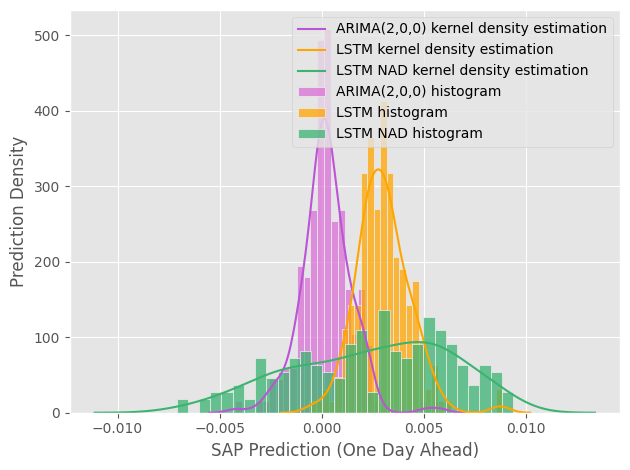

In [91]:
# Setting up the bins parameter for consistency across histograms
bins = 30  # Adjust the number of bins as needed

# ARIMA Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_arima', bins=bins, color='orchid', stat='density', label='ARIMA(2,0,0) histogram')

# ARIMA KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_arima', color='mediumorchid', label='ARIMA(2,0,0) kernel density estimation')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm', bins=bins, color='orange', stat='density', label='LSTM histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm', color='orange', label='LSTM kernel density estimation')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm_nad', bins=bins, color='mediumseagreen', stat='density', label='LSTM NAD histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm_nad', color='mediumseagreen', label='LSTM NAD kernel density estimation')

# Actual Histogram
#sns.histplot(data=results_comp['SAP_DE'], x='actual', bins=bins, color='blue', stat='density', label='Actual histogram')

# Actual KDE
#sns.kdeplot(data=results_comp['SAP_DE'], x='actual', color='blue', label='Actual kernel density estimation')

# Adding labels and adjusting layout
plt.xlabel('SAP Prediction (One Day Ahead)')
plt.ylabel('Prediction Density')
plt.tight_layout()
plt.legend()

# Uncomment the following line if you want to save the figure
#plt.savefig('hist_pred_sap.png')

plt.show()


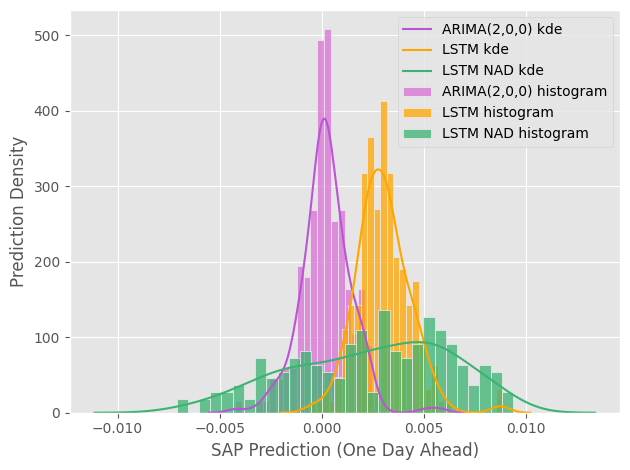

In [100]:
# Setting up the bins parameter for consistency across histograms
bins = 30  # Adjust the number of bins as needed

# ARIMA Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_arima', bins=bins, color='orchid', stat='density', label='ARIMA(2,0,0) histogram')

# ARIMA KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_arima', color='mediumorchid', label='ARIMA(2,0,0) kde')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm', bins=bins, color='orange', stat='density', label='LSTM histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm', color='orange', label='LSTM kde')

# LSTM Histogram
sns.histplot(data=results_comp['SAP_DE'], x='pred_lstm_nad', bins=bins, color='mediumseagreen', stat='density', label='LSTM NAD histogram')

# LSTM KDE
sns.kdeplot(data=results_comp['SAP_DE'], x='pred_lstm_nad', color='mediumseagreen', label='LSTM NAD kde')

# Actual Histogram
#sns.histplot(data=results_comp['SAP_DE'], x='actual', bins=bins, color='blue', stat='density', label='Actual histogram')

# Actual KDE
#sns.kdeplot(data=results_comp['SAP_DE'], x='actual', color='blue', label='Actual kernel density estimation')

# Adding labels and adjusting layout
plt.xlabel('SAP Prediction (One Day Ahead)')
plt.ylabel('Prediction Density')
plt.tight_layout()
plt.legend()

# Uncomment the following line if you want to save the figure
#plt.savefig('hist_pred_sap.png')

plt.show()


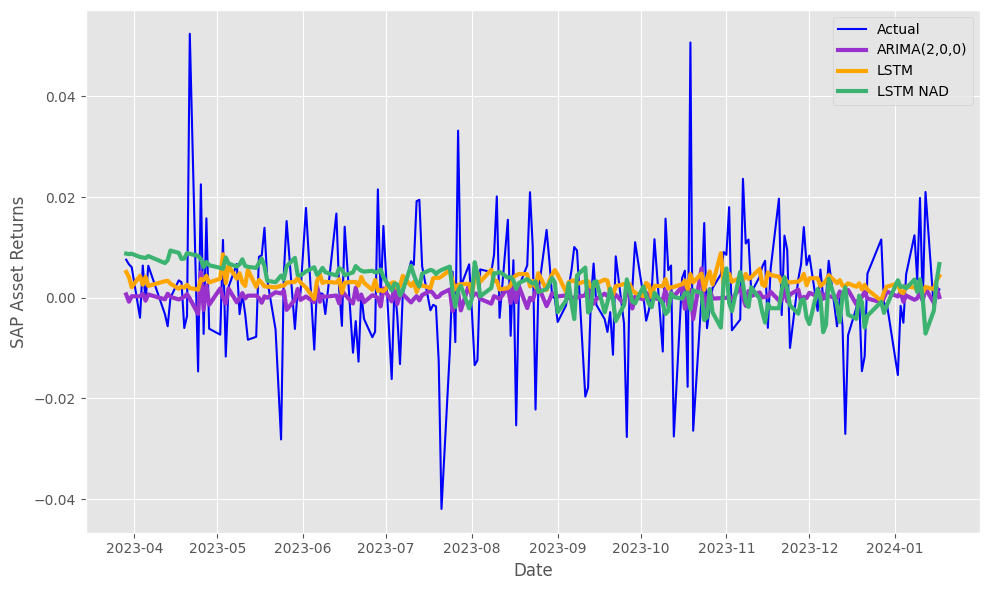

In [99]:
import matplotlib.dates as mdates

# Assuming results_comp['SAP_DE'] has a DateTimeIndex or the date information can be extracted
dates = results_comp['SAP_DE'].index  # Extract the dates corresponding to your data

#plot - sap asset return predictions
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size as needed
plt.plot(dates, results_comp['SAP_DE']['actual'], color='blue', label='Actual')
plt.plot(dates, results_comp['SAP_DE']['pred_arima'], color='darkorchid', label='ARIMA(2,0,0)', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm'], color='orange', label='LSTM', linewidth=3)
plt.plot(dates, results_comp['SAP_DE']['pred_lstm_nad'], color='mediumseagreen', label='LSTM NAD', linewidth=3)
#plt.plot(dates, results_comp['SAP_DE']['pred_lstm_nad'], color='lightgreen', label='LSTM NAD', linewidth=3)

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
#plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability

plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()

plt.show()